In [1]:
#Import necessary packages

import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score,precision_recall_fscore_support,f1_score,classification_report
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Read the empowerment data
data = pd.read_csv(r"RIVM_labelled_corpus.csv")
data.head(2)

,threadid,postid,threadid_postid,author,timestamp,labels,content of post
0,1,1,1_1,a9beaa20-89b2-0130-daa8-5a0007c06fd5,2013-04-17T20:25:04.422+02:00,narrative,Welkom in deze discussiegroep over vermoeidhei...
1,1,1374,1_1374,3de9bcf0-8d6b-0130-dc3e-5a0007c06fd5,2013-07-01T16:13:51.979+02:00,"narrative,question",In juni 2012 is er slokdamkanker bij mij gecon...


In [4]:
#Preprocess all the text
def preprocess(text):
    text = text.lower()
    text = re.sub("\n"," ",text) #Remove all next lines
    text = re.sub(r'<[^>]+>',"",text) # remove all html markup
    text = re.sub('[^a-zèéeêëėęûüùúūôöòóõœøîïíīįìàáâäæãåçćč&@#A-ZÇĆČÉÈÊËĒĘÛÜÙÚŪÔÖÒÓŒØŌÕÎÏÍĪĮÌ0-9- \']', "", text) #Remove special characters
    text = re.sub("\?","question_mark",text) #Replace question mark as mentioned in the paper
    return text

In [41]:
# Drop any rows from the DataFrame data that contain missing values (NaN) and split the labels into a list of labels
data = data.dropna()
data["new labels"] = data["labels"].apply(lambda row:str(row).split(","))

# Remove rows where labels occur only once
value_counts = data["new labels"].value_counts()
data = data[data['new labels'].isin(value_counts[value_counts != 1].index)]

# Apply the preprocessing function to the data column
data['content of post preprocessed'] = data['content of post'].apply(preprocess)

# Convert data into numerical format
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(list(data["new labels"]))

# Vectorization of data contents
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['content of post preprocessed'])
X = vectorizer.transform(data['content of post preprocessed'])
print("Vectorized text shape:", X.shape)

Vectorized text shape: (5049, 32389)


In [6]:
# Splitting the dataset while maintaining the label balance
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

# Print shapes to verify the split
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (4039, 32389) (4039, 5)
Testing set shape: (1010, 32389) (1010, 5)


In [7]:
#Multi label classifier (The value C=1.0 is as per the empowerment paper)
clf = OneVsRestClassifier(LinearSVC(C=1.0, max_iter=10000, random_state=42))

In [8]:
# Train the model
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
f1_score = f1_score(y_test, y_pred, average =None)
print("f1_score:", f1_score)

f1_score: [0.81355932 0.73228346 0.76396396 0.94893617 0.8       ]


In [60]:
mlb.inverse_transform(y_pred)

[('narrative',),
 ('narrative',),
 ('narrative',),
 ('external_source', 'informational_support', 'question'),
 ('informational_support', 'narrative'),
 ('narrative',),
 ('informational_support',),
 ('informational_support', 'narrative'),
 ('emotional_support', 'narrative'),
 (),
 ('narrative',),
 ('narrative',),
 ('emotional_support',),
 ('emotional_support', 'narrative'),
 ('narrative', 'question'),
 ('question',),
 ('question',),
 ('narrative',),
 ('emotional_support', 'narrative'),
 ('narrative',),
 ('emotional_support', 'narrative'),
 ('narrative',),
 ('narrative',),
 ('emotional_support', 'narrative'),
 ('narrative', 'question'),
 ('external_source', 'informational_support'),
 ('narrative',),
 ('external_source',),
 ('narrative',),
 ('emotional_support', 'narrative'),
 ('narrative',),
 ('emotional_support', 'narrative'),
 ('narrative',),
 ('narrative',),
 ('narrative',),
 ('narrative', 'question'),
 ('narrative',),
 ('narrative', 'question'),
 ('emotional_support',),
 ('narrative'

In [9]:
# Compute precision, recall, and F1 score for each label
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

# Get the label names
label_names = mlb.classes_

# Print results for each label
for i, label in enumerate(label_names):
    print(f"Label: {label}")
    print(f"  Precision: {precision[i]}")
    print(f"  Recall: {recall[i]}")
    print(f"  F1 Score: {f1_score[i]}")
    print()

Label: emotional_support
  Precision: 0.96
  Recall: 0.7058823529411765
  F1 Score: 0.8135593220338982

Label: external_source
  Precision: 0.8857142857142857
  Recall: 0.6241610738255033
  F1 Score: 0.732283464566929

Label: informational_support
  Precision: 0.848
  Recall: 0.6950819672131148
  F1 Score: 0.7639639639639639

Label: narrative
  Precision: 0.9356643356643357
  Recall: 0.962589928057554
  F1 Score: 0.948936170212766

Label: question
  Precision: 0.8962264150943396
  Recall: 0.7224334600760456
  F1 Score: 0.8



In [10]:
print(classification_report(y_test, y_pred,target_names=label_names))

                       precision    recall  f1-score   support

    emotional_support       0.96      0.71      0.81       170
      external_source       0.89      0.62      0.73       149
informational_support       0.85      0.70      0.76       305
            narrative       0.94      0.96      0.95       695
             question       0.90      0.72      0.80       263

            micro avg       0.91      0.81      0.86      1582
            macro avg       0.91      0.74      0.81      1582
         weighted avg       0.91      0.81      0.85      1582
          samples avg       0.90      0.85      0.85      1582



In [11]:
accuracy_score(y_test, y_pred)

0.6702970297029703

In [64]:
test_data = pd.read_csv("data4ektha.csv")

In [65]:
test_data1= list(test_data["text.y"])

In [66]:
def predict_new_text(new_text):
    # Preprocess the new text
    preprocessed_text = preprocess(new_text)

    # Vectorize the preprocessed text
    X_new = vectorizer.transform([preprocessed_text])
    # Predict the labels
    #print("Vectorized text shape:", X_new.shape)
    y_new_pred = clf.predict(X_new)
    # Inverse transform the predicted labels to get the original label names
    predicted_labels = mlb.inverse_transform(y_new_pred)
    return predicted_labels

In [69]:
predicted_labels = []
for i in test_data1:
  predicted_labels.append(predict_new_text(i))

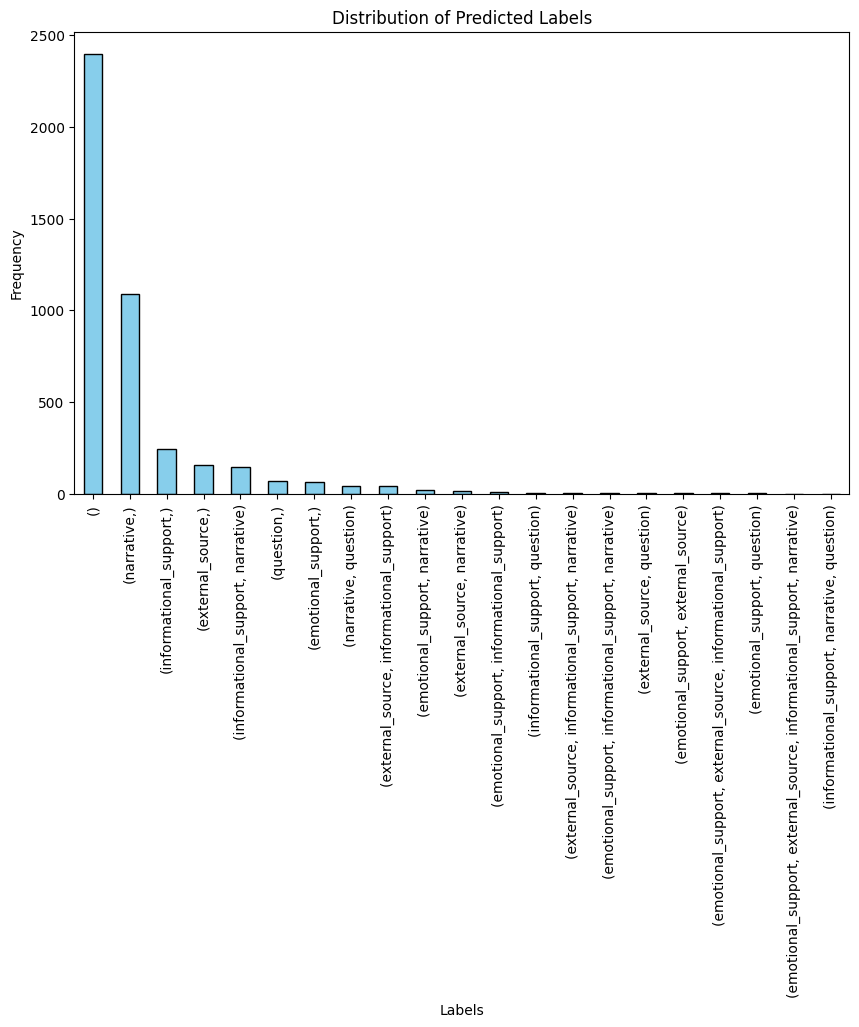

In [71]:
import matplotlib.pyplot as plt
all_labels = [label for sublist in predicted_labels for label in sublist]
# Get the frequency count of each label
label_counts = pd.Series(all_labels).value_counts()
# Plot the distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar',color='skyblue', edgecolor='black')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Labels')
plt.show()